# Aprendizaje de Máquina - Proyecto Final
## Ciro Iván García López


Librerias necesarias para la lectura y manejo de los datos.
- pandas : encargada de construir, leer y manipular el conjunto de datos.
- numpy : se encarga del casteo de tipos, es decir convertir todo a float64.
- mathplotlib : permite generar gráficas a partir de un conjunto de datos. 
- seaborn : permite generar el mapa de calor para la correlación de los datos.
- scipy : libreria de herramientas estadisticas. 
- sklearn : libreria de herramientas para aprendizaje. 
- keras : librería para el manejo de redes neuronales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.polynomial.polynomial as poly
import keras
import math

from sklearn.linear_model import Lasso
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical
from numpy.random import seed
from numpy.random import randn
seed(1)


Funciones auxiliares para la creación de DataFrames
- dfBuild : construye un DataFrame dado un arreglo
- dfBuildIny : construye un DataFrame dado un arreglo($dt$) y una potencia($n$), el dataframe resultante tendrá la forma: $\mid dt \mid dt^2 \mid ... \mid dt^n $

In [2]:
def dfBuild(dt):
    return pd.DataFrame(data={"x1":dt})

def dfBuildIny(dt,t):
    df = pd.DataFrame()
    for i in range(0,t):
        s = "x"+str(i+1)
        df.insert(i,s,dt**(i+1))
    return df

Funciones auxiliares para el cálculo de RSS y AIC, versión polinomial y por predicción.

In [3]:
def getRA(x, y, model,M):
    RSS = 0.5*np.sum((y-model(x))**2)
    AIC = len(x)*math.log10(RSS/len(x))+ 2*M*len(x)/(len(x)-M-1)
    return RSS,AIC

def getRAP(x, y, model,M):
    RSS = 0.5*np.sum( (y-model.predict(dfBuildIny(x,M)))**2 )
    AIC = len(x)*math.log10(RSS/len(x)) + 2*M*len(x)/(len(x)-M-1)
    return RSS,AIC

Algunos parámetros de configuración globales. Se tiene una configuración por defecto, la cual puede producir un desempeño pobre de los resultados.

In [318]:
#Configuración de los mensajes para las redes, 0 : sin mensajes.
verboseOp = 0
#Número de Epochs para el punto dos.
epochsDos = 10
#Número de Epochs para el punto tres.
epochsTres = 10
#Número de Epochs para el punto cuatro.
epochsCuatro = 50
#Tamaño del conjunto de datos de entrenamiento y validación para el punto 4.
trainSize = 500
testSize = 50000

## Punto 1

### Lectura y preparación de los datos.
Se hace la lectura de los datos así como la preparación de los mismos. Para este problema tanto los datos de entrenamiento como de validación se encuentran en el archivo *problem1.csv*.

In [4]:
archivoUno = 'problem1.csv'
datosUno = pd.read_csv(archivoUno)
datosUno.head(3)

,X_training,Y_training,X_test,Y_test
0,-2.00,22.067387,2.00,6.024049
1,-1.97,19.944915,2.05,6.885408
2,-1.94,18.062490,2.10,7.578968


Se separan los datos para las regresiones Lasso y Polynomial. Se comienza creando los arreglos con los datos de entranemiento

In [5]:
#Datos originales para x, en arreglo
xTrainUno = datosUno["X_training"]
yTrainUno = datosUno["Y_training"]
xTrainUno.head(3)

0   -2.00
1   -1.97
2   -1.94
Name: X_training, dtype: float64

Separación de los datos de validación. Observe la intrucción *dropna*; la lectura del archivo introduce estos valores, pero no hacen parte del archivo de datos csv.

In [6]:
#Datos originales para x, en arreglo
xTestUno = datosUno["X_test"].dropna()
yTestUno = datosUno["Y_test"].dropna()
xTestUno.head(3)

0    2.00
1    2.05
2    2.10
Name: X_test, dtype: float64

### Gráfica de los datos. 

Se grafican los datos para conocer su comportamiento.

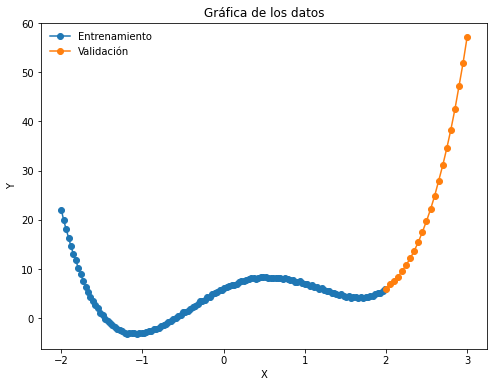

In [7]:
plt.figure(figsize=(8, 6))
plt.title("Gráfica de los datos")
plt.plot(xTrainUno, yTrainUno, '-o', label="Entrenamiento")
plt.plot(xTestUno,yTestUno, '-o', label="Validación")
plt.ylabel("Y")
plt.xlabel("X")
plt.legend(loc='best', frameon=False)
plt.show()

### Regresión usando Polyfit

Se procede a hacer una regresión de los datos usando Polyfit con un polinomio de grado arbitrario.

In [10]:
coefUno = poly.polyfit(xTrainUno, yTrainUno, 3)
modelUno = poly.Polynomial(coefUno)
print("El polinomio para la regresión es:")
modelUno

El polinomio para la regresión es:


Polynomial([ 3.20942252,  8.09866596,  0.91824065, -3.04861233], domain=[-1,  1], window=[-1,  1])

Se grafica el polinomio obtenido y se contrasta con los datos.

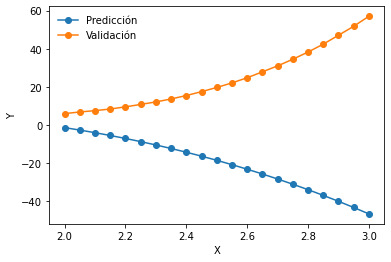

In [11]:
plt.plot(xTestUno, modelUno(xTestUno),'-o', label='Predicción')
plt.plot(xTestUno, yTestUno,'-o', label='Validación')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best', frameon=False)
plt.show()

Se observa un resultado pobre por parte del polinomio obtenido.

### AIC
Se buscará el grado del mejor polinomio por medio del criterio AIC.

In [15]:
#Se define el grado máximo hasta el cual se llega en la búsqueda
Pol_Max = 15
RSSv = np.zeros(Pol_Max-4)
AICv = np.zeros(Pol_Max-4)

#Se descartan los valores menores a 3, 
#pues la gráfica de los datos no tiene un comportamiento de este tipo
for i in np.arange(4,Pol_Max,1):
    coef = poly.polyfit(xTrainUno, yTrainUno, i)
    model = poly.Polynomial(coef)
    #Cálculo de RSS Y AIC
    rt, at = getRA(xTrainUno,yTrainUno,model,len(coef))
    RSSv[i-4] = rt
    AICv[i-4] = at    

Se grafican los valores obtenidos para el AIC.

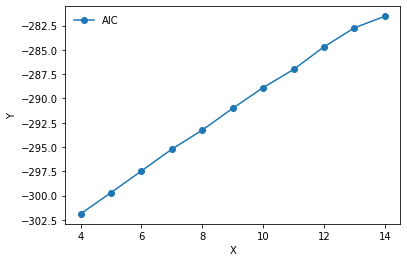

In [16]:
idx = np.arange(4,Pol_Max,1)
plt.plot(idx, AICv,'-o', label='AIC')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best', frameon=False)
plt.show()

Se selecciona el grado con el mejor desempeño en AIC.

In [23]:
bestGrade = np.argmin(AICv)+4
print("El mejor grado es de:",bestGrade)
print("El mejor AIC es de: ",AICv[bestGrade-4])
bestCoef = poly.polyfit(xTrainUno, yTrainUno, bestGrade)
bestPoly = poly.Polynomial(bestCoef)
print("El polinomio obtenido es:")
bestPoly

El mejor grado es de: 4
El mejor AIC es de:  -301.88036630232557
El polinomio obtenido es:


Polynomial([ 6.0000592 ,  8.02956741, -5.99141415, -3.00869471,  1.99588109], domain=[-1,  1], window=[-1,  1])

Se grafican los datos de validación vs los valores que obtiene el mejor polinomio.

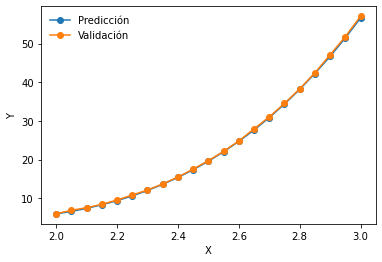

In [24]:
plt.plot(xTestUno, bestPoly(xTestUno),'-o', label='Predicción')
plt.plot(xTestUno, yTestUno,'-o', label='Validación')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best', frameon=False)
plt.show()

### AIC Lasso 

Se usa una regresión Lasso para observar si se puede obtener alguna mejora. Por lo que entonces se buscará ahora el mejor $\alpha$.

In [56]:
#Número de iteracciones.
Pol_Max = 1000
RSSv = np.zeros(Pol_Max)
AICv = np.zeros(Pol_Max)

for i in np.arange(0,Pol_Max,1):
    lassoTmp = Lasso(alpha=(i+1)/Pol_Max, max_iter=1e9)
    lassoTmp.fit(dfBuildIny(xTrainUno,bestGrade), yTrainUno)
    #Cálculo de RSS y AIC
    rt, at = getRAP(xTrainUno,yTrainUno,lassoTmp,bestGrade)  
    RSSv[i] = rt
    AICv[i] = at


Se grafican los valores de AIC obtenidos.

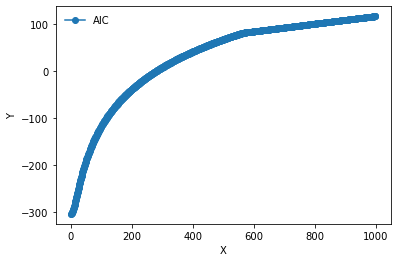

In [57]:
idx = np.arange(0,Pol_Max,1)
plt.plot(idx, AICv,'-o', label='AIC')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best', frameon=False)
plt.show()

In [58]:
bestAlpha = (np.argmin(AICv)+1)/Pol_Max
print("El mejor valor de alpha es:",bestAlpha)
print("El mejor AIC es de:",AICv[np.argmin(AICv)])
bestLasso = Lasso(alpha=bestAlpha, max_iter=1e9)
bestLasso.fit(dfBuildIny(xTrainUno,bestGrade), yTrainUno)

El mejor valor de alpha es: 0.001
El mejor AIC es de: -303.8779898079792


Lasso(alpha=0.001, max_iter=1000000000.0)

In [59]:
print("El polinomio obtenido por Lasso es:")
poly.Polynomial(np.insert(bestLasso.coef_,0,0))

El polinomio obtenido por Lasso es:


Polynomial([ 0.        ,  8.0234504 , -5.97927885, -3.00649076,  1.99261894], domain=[-1,  1], window=[-1,  1])

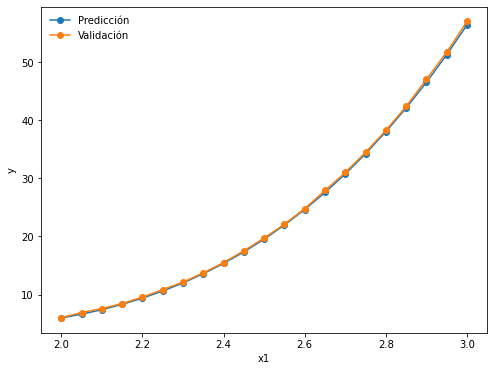

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(xTestUno, bestLasso.predict(dfBuildIny(xTestUno,bestGrade)),'-o', label='Predicción')
plt.plot(xTestUno, yTestUno,'-o', label='Validación')
plt.legend(loc='best', frameon=False)
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

Por el criterio AIC, no se obtiene mejoria significativa al usar Lasso.

### Cross Validation 
Se ejecutan dos evaluaciones cruzadas. Para empezar se evalua el modelo Lasso con el parámetro $\alpha$ obtenido anteriormente.

In [276]:
print("Resultados de la validación cruzada:",
    np.mean(cross_val_score(Lasso(alpha=bestAlpha), 
    dfBuildIny(xTrainUno,bestGrade), yTrainUno, cv=5)))

Resultados de la validación cruzada: 0.9731587797297578


Se obtiene un valor cercano a uno, por lo que entonces se tiene que es un buen modelo. Ahora se hace una búsqueda del mejor parámetro alpha en un rango de valores. 

In [278]:
alphas = np.arange(0.001,0.2 ,0.001)
cvModel = GridSearchCV(Lasso(),
                        param_grid={'alpha': degrees},
                        scoring='neg_mean_squared_error')
cvModel.fit(dfBuildIny(xTrainUno,bestGrade), yTrainUno);

Se obtiene el mismo valor para $\alpha$.

In [279]:
cv_model.best_params_, cv_model.best_estimator_.coef_

({'alpha': 0.001}, array([ 8.0234504 , -5.97927885, -3.00649076,  1.99261894]))

<!-- -->

<!-- -->

<!-- -->

## Punto 2
Creación del operador &(amp) usando una red neuronal secuencial de 3 capas densas. La señal de activación escogida para la capa final es una sigmoidal.


In [96]:
#Tabla de verdad
xTrainAmp = np.array([[0,0],[0,1],[1,0],[1,1]])
yTrainAmp = np.array([[1],[1],[1],[0]])

#Red neuronal, modelo secuencial de 3 capas densa
ampModel = Sequential()
ampModel.add(Dense(15, activation='relu',input_dim=2))
ampModel.add(Dense(15, activation='relu'))
ampModel.add(Dense(15, activation='relu'))
ampModel.add(Dense(1, activation='sigmoid'))
ampModel.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

#Entrenamiento de la red, observe que se desactivaron los mensajes
ampModel.fit(xTrainAmp, yTrainAmp, epochs=epochsDos,verbose=verboseOp)
print("Red para & entrenada")

Red para & entrenada


Se imprimen los valores que obtiene la red neuronal luego del entrenamiento, deben 'coincidir' con la tabla de verdad.

In [97]:
ampPredict = ampModel.predict(xTrainAmp)
pd.DataFrame(data={'A&B' : ampPredict.flat})

,A&B
0,0.530473
1,0.585677
2,0.584280
3,0.569473


Creación del operador $(dol) usando una red neuronal secuencial de 3 capas densas. La señal de activación escogida para la capa final es una sigmoidal. 

In [98]:
#Tabla de verdad
xTrainDol = np.array([[0,0],[0,1],[1,0],[1,1]])
yTrainDol = np.array([[0],[0],[0],[1]])

#Red neuronal secuencial densa de 3 capas
dolModel = Sequential()
dolModel.add(Dense(15, activation='relu',input_dim=2))
dolModel.add(Dense(15, activation='relu'))
dolModel.add(Dense(1, activation='sigmoid'))
dolModel.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

#Entrenamiento de la red, observe que se desactivaron los mensajes
dolModel.fit(xTrainDol, yTrainDol, epochs=epochsDos,verbose=verboseOp)
print("Red para $ entrenada")

Red para $ entrenada


Se imprimen los valores que obtiene la red neuronal luego del entrenamiento, deben 'coincidir' con la tabla de verdad.

In [99]:
dolPredict = dolModel.predict(xTrainDol)
pd.DataFrame(data={'A$B' : dolPredict.flat})

,A$B
0,0.479179
1,0.464427
2,0.407811
3,0.515800


Cómputo de la operación *(A&B)$C*.

In [100]:
#Representación de las entradas para A&B
A1 = np.array([[1.001,0], [0,1], [0.001,0], [1,1]])
#Cómputo de A&B
amp1 = ampModel.predict(A1)
#Representación de la entrada para (A&B)$C
A2 = np.array([[amp1[0][0],0], [amp1[1][0],1], [amp1[2][0],1], [amp1[3][0],0]])
#Cómputo de (A&B)$C
sol = dolModel.predict(A2)
#Impresión de las tablas
pd.DataFrame(data={ 'A' :  [1.001,0,0.001,1],
                    'B' :  [0,1,0,1],
                    'A&B' : amp1.flat,
                    'C' :  [0,1,1,0], 
                    '(A&B)$C': sol.flat })

,A,B,A&B,C,(A&B)$C
0,1.001,0,0.584329,0,0.439411
1,0.000,1,0.585677,1,0.500973
2,0.001,0,0.530487,1,0.498976
3,1.000,1,0.569473,0,0.440552


<!-- -->


<!-- -->

<!-- -->

## Punto 3
Se hace la lectura de los datos así como la preparación de los mismos. Para este proyecto los datos se encuentran en el archivo *problem3.csv.*

In [199]:
archivoTres = "problem3.csv"
datosTres = pd.read_csv(archivoTres)
datosTres.head(3)

,x_age,x_cholesterol,x_sugar,x_Tcell,y
0,35,220,80,550,0
1,18,240,120,600,0
2,22,260,55,580,0


Gráficas de los datos

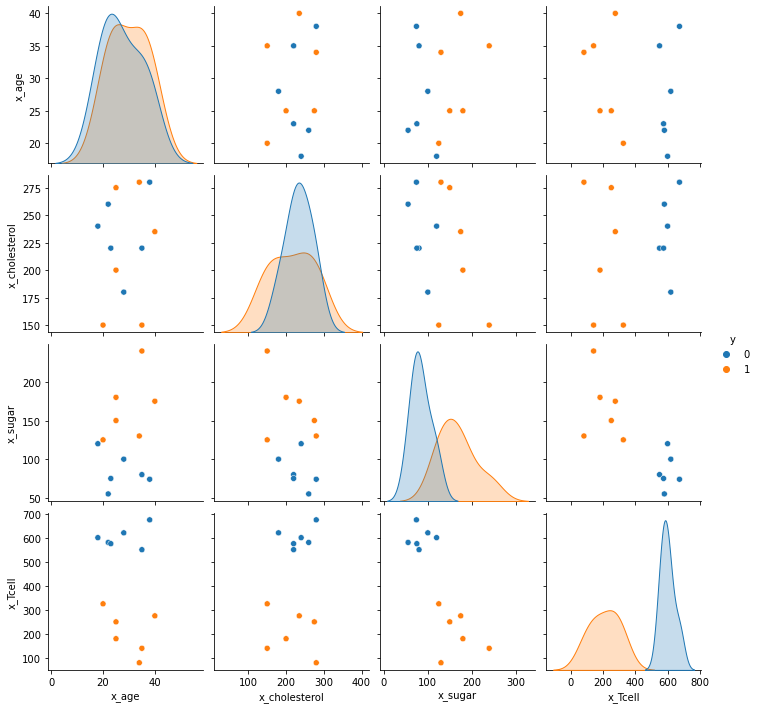

In [200]:
import seaborn as sns
sns.pairplot(datosTres, hue='y', markers='o')
plt.show()

Se imprime una matriz de correlación para poder encontrar las variables que mejor nos separen los datos.

Se dividen los datos para el entrenamiento y la validación.

In [222]:
from sklearn.model_selection import train_test_split
xTrainTres, xTestTres, yTrainTres, yTestTres = train_test_split(
    datosTres[['x_sugar']], datosTres['y'], test_size=0.2, random_state= 50)
yTrainTres.head(3)

3    0
2    0
7    1
Name: y, dtype: int64

Construcción del modelo de clasificación, se usa una red neuronal secuencial densa de 3 capas.

In [223]:
def classification_model():
    model = Sequential()
    model.add(Dense(8, activation='relu', input_dim=1))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(Adam(lr=0.04),'categorical_crossentropy',metrics=['accuracy'])
    return model

Se instancia la red neuronal

In [224]:
#Observe que se desactivaron los mensajes de Keras
classifier = KerasClassifier(build_fn = classification_model, 
                             epochs=epochsTres, batch_size=5, verbose=verboseOp)
kfold = KFold(n_splits=3)

In [219]:
results = cross_val_score(classifier, xTrainTres, yTrainTres, cv = kfold,verbose=0)


In [220]:

print("Rendimiento del modelo: Media: %.3f%% std: (%.2f%%)" % (results.mean()*100, results.std()*100))

Rendimiento del modelo: Media: 66.667% std: (0.00%)


In [221]:
model = classification_model()
model.fit(xTrainTres, yTrainTres, epochs=epochsTres, verbose=0)
scores = model.evaluate(xTestTres,yTestTres)
print('Accuracy: {}% \n Error: {}'.format(scores[1], 1 - scores[1]))   

1/1 [==============================] - 0s 306ms/step - loss: 3.0090e-05 - accuracy: 1.0000
Accuracy: 1.0% 
 Error: 0.0


<!-- --> 

<!-- -->

<!-- -->

## Punto 4
Se generan 500 puntos aleatorios para generar los datos de entrenamiento.

In [375]:
xTrainCuatro = randn(trainSize)
yTrainCuatro = randn(trainSize)

Se define el cono, $\frac{x^{2}}{2} + \frac{y^{2}}{2} = z^{2}$.

In [376]:
def Cono(x,y):
    return np.sqrt((x**2)/2 + (y**2)/2)

A partir de los puntos (x,y) se generan los puntos z.

In [377]:
zTrainCuatro = Cono(xTrainCuatro,yTrainCuatro)


Construcción del DataFrame con los datos (x,y).

In [378]:
trainCuatro = pd.DataFrame({'x': xTrainCuatro, 'y': yTrainCuatro})
trainCuatro.head(3)

,x,y
0,-0.395989,0.886321
1,-0.385048,-1.095601
2,1.207712,0.460458


Se crea la red neuronal, secuencial densa de 3 capas con 2 variables de entrada.

In [379]:
redCono = Sequential()
redCono.add(Dense(16, activation='relu', input_shape=(2,)))
redCono.add(Dense(16, activation='relu'))
redCono.add(Dense(16, activation='relu'))
redCono.add(Dense(16, activation='relu'))
redCono.add(Dense(1, activation='relu'))
    
redCono.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

Entrenamiento de la red neuronal

In [380]:
resultadosCono = redCono.fit( trainCuatro,  zTrainCuatro, 
                       validation_split=0.3, epochs=epochsCuatro, verbose=verboseOp)
print("Red para el Cono entrenada")

Red para el Cono entrenada


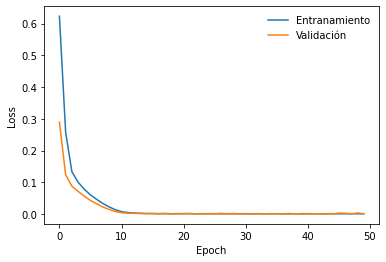

In [381]:
plt.plot(resultadosCono.history['loss'],label="Entranamiento")
plt.plot(resultadosCono.history['val_loss'],label="Validación")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best', frameon=False)
plt.show()

Se define el tamaño de los datos de validación y se generan los puntos para la validación.

In [382]:
xTestCuatro = randn(testSize)
yTestCuatro = randn(testSize)
testCuatro = pd.DataFrame({'x': xTestCuatro, 'y': yTestCuatro})
testCuatro.head()

,x,y
0,0.609659,-0.176805
1,1.796760,1.258665
2,-0.426300,0.317613
3,1.383253,-1.387163
4,0.537067,0.741837


In [383]:
test_mse_score, test_mae_score = redCono.evaluate(
    testCuatro, Cono(xTestCuatro,yTestCuatro))
test_mae_score

1563/1563 [==============================] - 3s 2ms/step - loss: 7.1458e-04 - mae: 0.0235


0.02346228063106537

Se generan las predicciones para el conjunto de datos de validación.

In [384]:
prediccionesCono = redCono.predict(testCuatro)

Se grafican los datos reales versus los predecidos.

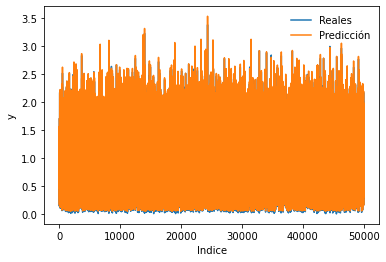

In [385]:
plt.plot(np.arange(testSize),Cono(xTestCuatro,yTestCuatro),label="Reales")
plt.plot(np.arange(testSize),prediccionesCono,label="Predicción")
plt.legend(loc='best', frameon=False)
plt.ylabel('y')
plt.xlabel('Indice')
plt.show()

Se dibuja el cono con los datos predecidos.

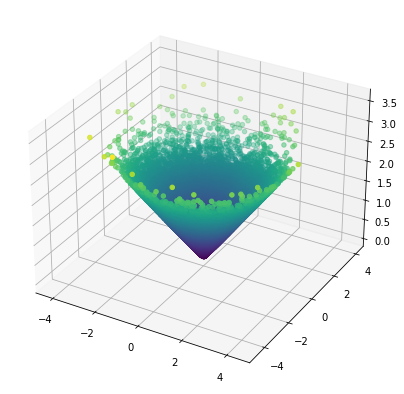

In [386]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot( projection='3d')
ax.scatter(xTestCuatro,yTestCuatro,prediccionesCono,c=prediccionesCono)
plt.show()

<!-- --> 

<!-- --> 

<!-- --> 

<!-- --> 

## Conclusiones
- La calibración de paramétros (epoch, activation, etc) es un paso fundamental en el 
trabajo con redes neuronales. Sin embargo como menciona [1] no existe una manera exacta y se deben probar distintas configuraciones para obtener la mejor. 

## Referencias
- [Polynomial Regression Using Scikit](https://stats.stackexchange.com/questions/58739/polynomial-regression-using-scikit-learn)
- [Creating a simple neural network in Python ](https://broutonlab.com/blog/tutorial-create-simple-neural-network)
- [Using cross-validation to evaluate different models — Regression](https://medium.com/analytics-vidhya/using-cross-validation-to-evaluate-different-models-regression-5f61ec89531)